In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from vit_pytorch import ViT

cudnn.becnmark = True
plt.ion()

## Load the data

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the data
data_dir = '/home/admin1/CSD/ALaM/Jom/Vision_Transformer/Transfer Learning/Eurosat'
image_datasets = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split the data
train_size = int(0.8 * len(image_datasets))
val_size = len(image_datasets) - train_size
train_data, val_data = torch.utils.data.random_split(image_datasets, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}

# Dataset sizes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}
class_names = image_datasets.classes

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [4]:
for _, labels in dataloaders['train']:
    print(labels)
    break
labels.shape

tensor([6, 2, 7, 2, 3, 0, 7, 7, 1, 4, 4, 9, 6, 6, 9, 8, 8, 7, 5, 2, 7, 2, 3, 3,
        4, 1, 2, 1, 3, 9, 7, 5])


torch.Size([32])

#### Visualize a few images

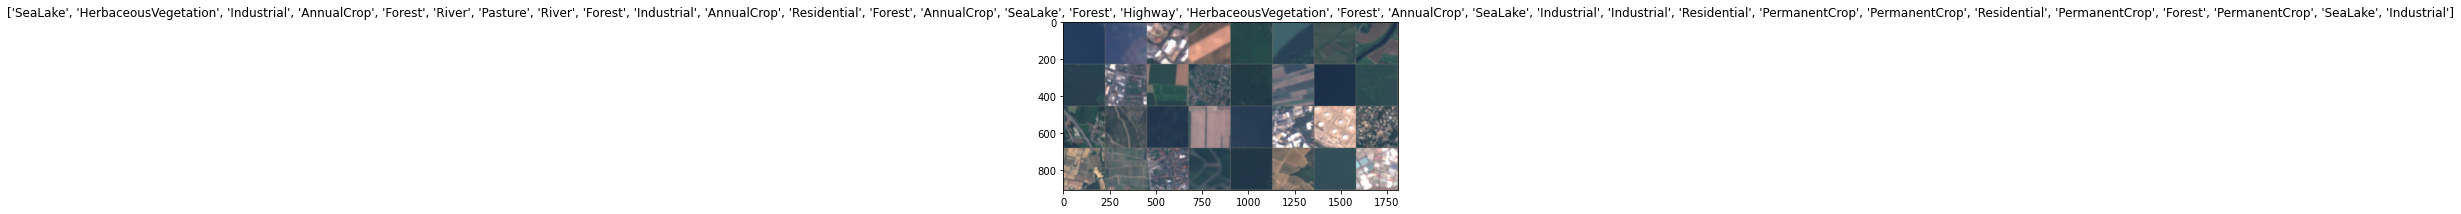

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training function

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_, preds = torch.max(outputs, 1)
                    labels = labels.long()
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds, torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Instantiate the model

In [6]:
class VanillaViT(nn.Module):
    def __init__(self,image_size = 224, patch_size = 16, num_classes = 1, dim = 1024, depth = 16, heads = 16,
                mlp_dim = 2048, dropout = 0.1, emb_dropout = 0.1 ):
        super(VanillaViT, self).__init__()
        self.model = ViT(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, 
                         heads=heads, mlp_dim=mlp_dim, dropout=dropout, emb_dropout=emb_dropout)
       
    def forward(self, x):
        output = self.model(x)
        
        return output
    
model = VanillaViT(num_classes=10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [7]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=500)

Epoch 0 / 499
----------
train Loss: 1.6679 Acc: 0.3864
val Loss: 1.5185 Acc: 0.4904
Epoch 1 / 499
----------
train Loss: 1.2798 Acc: 0.5400
val Loss: 1.2974 Acc: 0.5696
Epoch 2 / 499
----------
train Loss: 1.1159 Acc: 0.6022
val Loss: 0.9929 Acc: 0.6511
Epoch 3 / 499
----------
train Loss: 1.0175 Acc: 0.6378
val Loss: 0.9683 Acc: 0.6537
Epoch 4 / 499
----------
train Loss: 0.9456 Acc: 0.6615
val Loss: 0.9874 Acc: 0.6543
Epoch 5 / 499
----------
train Loss: 0.8929 Acc: 0.6805
val Loss: 1.0660 Acc: 0.6409
Epoch 6 / 499
----------
train Loss: 0.8451 Acc: 0.6979
val Loss: 0.8044 Acc: 0.7220
Epoch 7 / 499
----------
train Loss: 0.8111 Acc: 0.7126
val Loss: 0.8114 Acc: 0.7183
Epoch 8 / 499
----------
train Loss: 0.7862 Acc: 0.7221
val Loss: 0.8236 Acc: 0.7113
Epoch 9 / 499
----------
train Loss: 0.7755 Acc: 0.7269
val Loss: 0.7994 Acc: 0.7241
Epoch 10 / 499
----------
train Loss: 0.7700 Acc: 0.7289
val Loss: 0.8107 Acc: 0.7178
Epoch 11 / 499
----------
train Loss: 0.7714 Acc: 0.7279
val Los

val Loss: 0.3212 Acc: 0.8937
Epoch 96 / 499
----------
train Loss: 0.3101 Acc: 0.8956
val Loss: 0.3605 Acc: 0.8800
Epoch 97 / 499
----------
train Loss: 0.3174 Acc: 0.8939
val Loss: 0.3441 Acc: 0.8909
Epoch 98 / 499
----------
train Loss: 0.3162 Acc: 0.8925
val Loss: 0.3257 Acc: 0.8939
Epoch 99 / 499
----------
train Loss: 0.3184 Acc: 0.8931
val Loss: 0.3294 Acc: 0.8933
Epoch 100 / 499
----------
train Loss: 0.3184 Acc: 0.8933
val Loss: 0.3271 Acc: 0.8930
Epoch 101 / 499
----------
train Loss: 0.3078 Acc: 0.8947
val Loss: 0.3954 Acc: 0.8656
Epoch 102 / 499
----------
train Loss: 0.3107 Acc: 0.8979
val Loss: 0.3333 Acc: 0.8928
Epoch 103 / 499
----------
train Loss: 0.2945 Acc: 0.9000
val Loss: 0.3619 Acc: 0.8756
Epoch 104 / 499
----------
train Loss: 0.2912 Acc: 0.9022
val Loss: 0.2920 Acc: 0.9043
Epoch 105 / 499
----------
train Loss: 0.2800 Acc: 0.9074
val Loss: 0.3065 Acc: 0.9013
Epoch 106 / 499
----------
train Loss: 0.2710 Acc: 0.9107
val Loss: 0.2793 Acc: 0.9104
Epoch 107 / 499
--

train Loss: 0.1877 Acc: 0.9393
val Loss: 0.2459 Acc: 0.9217
Epoch 191 / 499
----------
train Loss: 0.1816 Acc: 0.9413
val Loss: 0.2400 Acc: 0.9207
Epoch 192 / 499
----------
train Loss: 0.1863 Acc: 0.9391
val Loss: 0.2358 Acc: 0.9206
Epoch 193 / 499
----------
train Loss: 0.1855 Acc: 0.9387
val Loss: 0.2415 Acc: 0.9194
Epoch 194 / 499
----------
train Loss: 0.1931 Acc: 0.9367
val Loss: 0.2410 Acc: 0.9228
Epoch 195 / 499
----------
train Loss: 0.1992 Acc: 0.9341
val Loss: 0.2488 Acc: 0.9191
Epoch 196 / 499
----------
train Loss: 0.2063 Acc: 0.9312
val Loss: 0.2513 Acc: 0.9174
Epoch 197 / 499
----------
train Loss: 0.2177 Acc: 0.9271
val Loss: 0.2725 Acc: 0.9152
Epoch 198 / 499
----------
train Loss: 0.2259 Acc: 0.9249
val Loss: 0.2608 Acc: 0.9143
Epoch 199 / 499
----------
train Loss: 0.2218 Acc: 0.9260
val Loss: 0.2758 Acc: 0.9120
Epoch 200 / 499
----------
train Loss: 0.2273 Acc: 0.9241
val Loss: 0.2550 Acc: 0.9150
Epoch 201 / 499
----------
train Loss: 0.2225 Acc: 0.9260
val Loss: 0.

val Loss: 0.2330 Acc: 0.9281
Epoch 285 / 499
----------
train Loss: 0.1630 Acc: 0.9470
val Loss: 0.2425 Acc: 0.9246
Epoch 286 / 499
----------
train Loss: 0.1504 Acc: 0.9519
val Loss: 0.2152 Acc: 0.9328
Epoch 287 / 499
----------
train Loss: 0.1495 Acc: 0.9506
val Loss: 0.2239 Acc: 0.9243
Epoch 288 / 499
----------
train Loss: 0.1405 Acc: 0.9546
val Loss: 0.2138 Acc: 0.9328
Epoch 289 / 499
----------
train Loss: 0.1399 Acc: 0.9555
val Loss: 0.2202 Acc: 0.9319
Epoch 290 / 499
----------
train Loss: 0.1469 Acc: 0.9528
val Loss: 0.2139 Acc: 0.9348
Epoch 291 / 499
----------
train Loss: 0.1427 Acc: 0.9535
val Loss: 0.2165 Acc: 0.9331
Epoch 292 / 499
----------
train Loss: 0.1432 Acc: 0.9545
val Loss: 0.2139 Acc: 0.9328
Epoch 293 / 499
----------
train Loss: 0.1469 Acc: 0.9519
val Loss: 0.2179 Acc: 0.9331
Epoch 294 / 499
----------
train Loss: 0.1488 Acc: 0.9503
val Loss: 0.2086 Acc: 0.9330
Epoch 295 / 499
----------
train Loss: 0.1594 Acc: 0.9473
val Loss: 0.2372 Acc: 0.9256
Epoch 296 / 49

train Loss: 0.1568 Acc: 0.9487
val Loss: 0.2621 Acc: 0.9196
Epoch 380 / 499
----------
train Loss: 0.1544 Acc: 0.9481
val Loss: 0.2511 Acc: 0.9250
Epoch 381 / 499
----------
train Loss: 0.1443 Acc: 0.9511
val Loss: 0.2537 Acc: 0.9230
Epoch 382 / 499
----------
train Loss: 0.1444 Acc: 0.9511
val Loss: 0.2132 Acc: 0.9320
Epoch 383 / 499
----------
train Loss: 0.1472 Acc: 0.9515
val Loss: 0.2324 Acc: 0.9313
Epoch 384 / 499
----------
train Loss: 0.1334 Acc: 0.9554
val Loss: 0.2256 Acc: 0.9300
Epoch 385 / 499
----------
train Loss: 0.1356 Acc: 0.9556
val Loss: 0.2306 Acc: 0.9254
Epoch 386 / 499
----------
train Loss: 0.1317 Acc: 0.9573
val Loss: 0.2290 Acc: 0.9322
Epoch 387 / 499
----------
train Loss: 0.1178 Acc: 0.9625
val Loss: 0.2088 Acc: 0.9315
Epoch 388 / 499
----------
train Loss: 0.1216 Acc: 0.9606
val Loss: 0.2087 Acc: 0.9346
Epoch 389 / 499
----------
train Loss: 0.1113 Acc: 0.9652
val Loss: 0.2201 Acc: 0.9311
Epoch 390 / 499
----------
train Loss: 0.1150 Acc: 0.9641
val Loss: 0.

val Loss: 0.2090 Acc: 0.9350
Epoch 474 / 499
----------
train Loss: 0.1054 Acc: 0.9666
val Loss: 0.2251 Acc: 0.9337
Epoch 475 / 499
----------
train Loss: 0.1063 Acc: 0.9644
val Loss: 0.2156 Acc: 0.9335
Epoch 476 / 499
----------
train Loss: 0.1169 Acc: 0.9636
val Loss: 0.2406 Acc: 0.9307
Epoch 477 / 499
----------
train Loss: 0.1230 Acc: 0.9594
val Loss: 0.2279 Acc: 0.9319
Epoch 478 / 499
----------
train Loss: 0.1237 Acc: 0.9588
val Loss: 0.2423 Acc: 0.9239
Epoch 479 / 499
----------
train Loss: 0.1308 Acc: 0.9575
val Loss: 0.2183 Acc: 0.9348
Epoch 480 / 499
----------
train Loss: 0.1321 Acc: 0.9551
val Loss: 0.2350 Acc: 0.9265
Epoch 481 / 499
----------
train Loss: 0.1278 Acc: 0.9592
val Loss: 0.2394 Acc: 0.9274
Epoch 482 / 499
----------
train Loss: 0.1296 Acc: 0.9567
val Loss: 0.2368 Acc: 0.9278
Epoch 483 / 499
----------
train Loss: 0.1224 Acc: 0.9588
val Loss: 0.2336 Acc: 0.9274
Epoch 484 / 499
----------
train Loss: 0.1193 Acc: 0.9633
val Loss: 0.2246 Acc: 0.9298
Epoch 485 / 49

In [8]:
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, timestr + '.pth')